In [2]:
#imports

import shlex, subprocess
import os , sys
import time

import numpy as np
from numpy import array
from numpy import argmax
import pandas as pd

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
import sklearn.metrics as metrics
from sklearn.metrics import confusion_matrix

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow import keras
import keras_tuner

from Bio import SeqIO

import matplotlib.pyplot as plt
import pylab as pl
import seaborn as sns    
        

2023-02-20 16:52:03.499713: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [3]:
#one hot encoding
def fasta_to_onehotencode(seq) : 
    #values = list(seq)
    #values = np.array(values)
    base2int = {'A': 0, 'C': 1, 'G': 2, 'T': 3}
    # label = int(line.strip()[1])
    
    
    sequence = seq 
    # Encode sequence bases as integers, i.e. A as 0, C as 1, etc.
    sequence_int = [base2int.get(base, 9999) for base in sequence]
    
    sequence_onehot = tf.one_hot(sequence_int, depth=4)
    
        
    return sequence_onehot

In [4]:
def fastatoarray(fasta_sequences) :
    seq_array = np.zeros((1,400,4)) 
    for fasta in fasta_sequences:
        name, sequence = fasta.id, str(fasta.seq)
        new_sequence = fasta_to_onehotencode(sequence) #onehotencode(sequence)
        new_sequence = np.expand_dims(new_sequence, axis =0)
        seq_array = np.vstack((seq_array,new_sequence))
    seq_array = np.delete(seq_array, 0, 0) #to remove the first array of zeros 
    return seq_array  

In [5]:
_start_time = time.time()
#change a bit this function or cite 
def tic():
    global _start_time 
    _start_time = time.time()

def tac():
    t_sec = round(time.time() - _start_time)
    (t_min, t_sec) = divmod(t_sec,60)
    (t_hour,t_min) = divmod(t_min,60) 
    print('Time passed: {}hour:{}min:{}sec'.format(t_hour,t_min,t_sec))

In [6]:
def prepare_dataset(path, current_folder) : 
    print('Starting preparation of the dataset for %s' %current_folder)
    
    folder = current_folder
    directory2 = os.listdir(path+ '/' + folder)
    seq_list_positive = np.zeros((1,400,4)) 
    seq_list_negative = np.zeros((1,400,4)) 
    seq_list_positive_test = np.zeros((1,400,4)) 
    seq_list_negative_test = np.zeros((1,400,4)) 

    for folder2 in directory2 :
        directory3 = os.listdir(path+ '/' + folder + '/' + folder2)

        if folder2 != "fold-4": #to be split into training and validation

            seq_list_positive_file = np.zeros((1,400,4)) 
            seq_list_negative_file = np.zeros((1,400,4)) 

            for file in directory3 :

                if "fasta" in file :
                    fasta_sequences = SeqIO.parse(open(path+ '/' + folder + '/' + folder2+ '/' + file),'fasta')
                    seq_array = fastatoarray(fasta_sequences)

                    if "positive" in file : 
                        seq_list_positive_file = np.vstack((seq_list_positive_file, seq_array))


                    if "negative-1" in file: # 2 neg: 1 pos with 'negative' --> 1 neg : 1 pos 'negative-1'
                        seq_list_negative_file = np.vstack((seq_list_negative_file, seq_array))

            seq_list_negative_file = np.delete(seq_list_negative_file, 0, 0)
            seq_list_positive_file = np.delete(seq_list_positive_file, 0, 0)

            seq_list_positive = np.vstack((seq_list_positive, seq_list_positive_file))
            seq_list_negative = np.vstack((seq_list_negative, seq_list_negative_file))



        if folder2 == "fold-4": #for testing

                seq_list_positive_test_file = np.zeros((1,400,4)) 
                seq_list_negative_test_file = np.zeros((1,400,4)) 

                for file in directory3 :

                    if "fasta" in file :
                        fasta_sequences = SeqIO.parse(open(path+ '/' + folder + '/' + folder2+ '/' + file),'fasta')
                        seq_array = fastatoarray(fasta_sequences)

                        if "positive" in file : 
                            seq_list_positive_test_file = np.vstack((seq_list_positive_test_file, seq_array))


                        if "negative-1" in file: 
                            seq_list_negative_test_file = np.vstack((seq_list_negative_test_file, seq_array))

                seq_list_negative_test_file = np.delete(seq_list_negative_test_file, 0, 0)
                seq_list_positive_test_file = np.delete(seq_list_positive_test_file, 0, 0)

                seq_list_positive_test = np.vstack((seq_list_positive_test, seq_list_positive_test_file))
                seq_list_negative_test = np.vstack((seq_list_negative_test, seq_list_negative_test_file))

                seq_list_negative_test = np.delete(seq_list_negative_test, 0, 0)
                seq_list_positive_test = np.delete(seq_list_positive_test, 0, 0)  



    seq_list_negative = np.delete(seq_list_negative, 0, 0)
    seq_list_positive = np.delete(seq_list_positive, 0, 0)
    
    
    #prep labels
    labels_positive = np.ones((np.shape(seq_list_positive)[0], 1))

    labels_negative = np.zeros((np.shape(seq_list_negative)[0], 1))

    labels_positive_test = np.ones((np.shape(seq_list_positive_test)[0], 1))

    labels_negative_test = np.zeros((np.shape(seq_list_negative_test)[0], 1))
    print('Shape of labels: \n-positive : ',np.shape(labels_negative),'\n-negative : ', np.shape(labels_negative),'\n-positive validation : ',np.shape(labels_positive_test),'\n-negative validation : ',np.shape(labels_negative_test))
    
    
    #merging datasets
    x = np.vstack((seq_list_positive, seq_list_negative))

    x_test = np.vstack((seq_list_positive_test, seq_list_negative_test))

    y = np.vstack((labels_positive, labels_negative))

    y_test = np.vstack((labels_positive_test, labels_negative_test))
    
    #creating the validation set

    #parameters 
    test_size = 0.2

    #test set

    x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=test_size, shuffle= True)
    x_test, y_test = shuffle(x_test, y_test, random_state=0)

    y_train = y_train.astype("float32")#actually useful?
    y_val =y_val.astype("float32")
    y_test = y_test.astype("float32")

    x_train = x_train.astype("float32")
    x_val = x_val.astype("float32")
    x_test =x_test.astype("float32")



    print('Shape of datasets: \n-training set : ',np.shape(x_train),'\n-validation set : ',np.shape(x_val),'\n-testing set : ', np.shape(x_test))
    
    #checking class ditribution in the whole dataset and training set

    print('Label frequencies among the dataset %s' %current_folder)
    plt.hist(y)
    plt.xticks(range(2))
    plt.title('Label Frequency')
    plt.show()

    plt.hist(y_train)
    plt.xticks(range(2))
    plt.title('Label Frequency training set')
    plt.show()

    plt.hist(y_val)
    plt.xticks(range(2))
    plt.title('Label Frequency validation set')
    plt.show()
    return x_train ,y_train ,x_val ,y_val ,x_test ,y_test

In [7]:
#tuning of the model architecture 
def build_model(hp):
    
    
    METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(curve= 'ROC',name='auroc'),
      keras.metrics.AUC(curve = 'PR', name='auprc')  
    ]

   
    #the first layer should be a convolutional layer
    #conv-maxpooling-dropout-conv-maxpooling-dropout-flatten-(dense-dropout)-dense --> this is the pysster architecture 
    #how long should the kernel be? 
    #the parameters are now the default ones from pysster
    
    input_shape = (400, 4)
    
    
    #hyperparameter search 
    
    hp_filters = hp.Int('filters', min_value = 10, max_value = 60, step = 10)
    hp_kernel_size = hp.Int('kernel_size', min_value = 10, max_value = 60, step = 5)
    hp_pool_size = hp.Int('pool_size', min_value = 1, max_value = 10, step = 1)
    hp_strides = hp.Int('strides', min_value = 1, max_value = 10, step = 1)
    hp_learning_rate = hp.Float("lr", min_value=1e-4, max_value=1e-2, sampling="log")
    #hp_padding = hp.Choice('padding', ['valid','same'])
    hp_padding = 'same' #so that there are no problems with input size after the convolutional layer
    hp_kernel_initializer = hp.Choice('initiaizer', ['random_normal','random_uniform'])
    hp_activation=hp.Choice("activation", ["relu", "tanh"])
    
    
    
    # create model
    
        
    model = keras.Sequential()
    
    model.add(keras.layers.InputLayer(input_shape= input_shape))
    #model.add(keras.layers.Dropout(0.3)) -- seems better without this step
    
    model.add(keras.layers.Conv1D(filters=hp_filters,kernel_size=hp_kernel_size,
              kernel_initializer=hp_kernel_initializer, 
              activation=hp_activation,input_shape=input_shape))
    model.add(keras.layers.MaxPooling1D(pool_size=hp_pool_size, strides=hp_strides, padding=hp_padding))#valid or same?  
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Conv1D(filters=hp_filters,kernel_size=hp_kernel_size,
              kernel_initializer= hp_kernel_initializer, 
              activation=hp_activation ,input_shape=input_shape ))
    model.add(keras.layers.MaxPooling1D(pool_size=hp_pool_size, strides=hp_strides, padding=hp_padding))
    model.add(keras.layers.Dropout(0.3))

    model.add(keras.layers.Flatten())#without parameters
    
    for i in range(hp.Int("num_layers", 1, 3)):
        model.add(
        layers.Dense(
            # Tune number of units separately.
            units=hp.Int(f"units_{i}", min_value=32, max_value=1024, step=32),
            activation = hp_activation
            )
        )
    if hp.Boolean("dropout"):
        model.add(layers.Dropout(rate=0.25))
    model.add(layers.Dense(10, activation=hp_activation))

    model.add(keras.layers.Dropout(0.6))

    model.add(keras.layers.Dense(1, activation='sigmoid'))#what should be the output shape? 1? 

    
    #many models train better when reducing the learning rate gradually -- not in this case!! see model2
    #lr_schedule = tf.keras.optimizers.schedules.InverseTimeDecay(
                                                                 # 0.001,
                                                                 # decay_steps=50*1000,
                                                                 # decay_rate=1,
                                                                  #staircase=False)
    
    
    # Compile model

    model.compile(loss='binary_crossentropy', optimizer=tf.keras.optimizers.Adam(hp_learning_rate), metrics=METRICS)
    
    
    return model
    
    

In [8]:
def prepare_best_model(x_train ,y_train ,x_val ,y_val ,x_test ,y_test, folder) : 
    
    METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(curve= 'ROC',name='auroc'),
      keras.metrics.AUC(curve = 'PR', name='auprc')  
    ]
    
    my_callbacks1 = [
        tf.keras.callbacks.EarlyStopping(patience=2), #better to reduce to 2 for the search 
        tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
        tf.keras.callbacks.TensorBoard(log_dir='./logs'),
        ]
    
    my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5), #better to reduce to 2 for the search 
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    ]


    model2 = build_model(keras_tuner.HyperParameters())

    print(model2.summary())

    
    tuner = keras_tuner.RandomSearch(
        hypermodel=build_model,
        #objective=keras_tuner.Objective("val_auroc", direction="max"), #val_loss , val_accuracy .... 77
        #objective = keras_tuner.Objective("val_loss", direction="min"),
        objective="val_accuracy",
        max_trials=200,
        executions_per_trial=1, #probably better to change to 1 and increase the max_trials
        overwrite=True,
        directory="my_dir",
        project_name="models",
        max_consecutive_failed_trials=10,
    )

    print(tuner.search_space_summary())


    tuner.search(x_train, y_train, epochs=5, validation_data=(x_val, y_val), callbacks = my_callbacks1)
    
    # Get the top 2 models.
    models2 = tuner.get_best_models(num_models=4)
    best_model2 = models2[0]
    # Build the model.
    # Needed for `Sequential` without specified `input_shape`.
    best_model2.build(input_shape=(None, 400, 4))
    best_model2.summary()

    
    best_hps = tuner.get_best_hyperparameters(5)
    # Build the model with the best hp.
    model2 = build_model(best_hps[0])
    # Fit with the entire dataset.

    history = model2.fit(x_train, y_train, epochs=200, validation_data= (x_val,y_val), callbacks = my_callbacks)
    
    
    
    # list all data in history --> add name of the rbp!!!!

    print(history.history.keys())
    
    plt.title('Best model evaluation for %s' %folder)
    
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # summarize history for auroc 
    plt.plot(history.history['auroc'])
    plt.plot(history.history['val_auroc'])
    plt.plot(history.history['auprc'])
    plt.plot(history.history['val_auprc'])
    plt.title('model auroc and auprc')
    plt.ylabel('auroc and auprc')
    plt.xlabel('epoch')
    plt.legend(['auroc_train', 'auroc_test','auprc_train', 'auprc_test'], loc='upper left')
    plt.show()
    
    model2.save('best_models/best_model_%s' %folder) 

In [20]:
def training_model(x_train ,y_train ,x_val ,y_val ,x_test ,y_test, folder) : 
    
    
    
    METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(curve= 'ROC',name='auroc'),
      keras.metrics.AUC(curve = 'PR', name='auprc')  
    ]
    
    
    my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=5), #better to reduce to 2 for the search 
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    ]

    model2 = keras.models.load_model('best_models/best_model5_AARS_K562')


    history = model2.fit(x_train, y_train, epochs=200, validation_data= (x_val,y_val), callbacks = my_callbacks)
    
    
    
    # list all data in history --> add name of the rbp!!!!

    print(history.history.keys())
    
    plt.title('Best model evaluation for %s' %folder)
    
    # summarize history for accuracy
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()
    # summarize history for loss
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper left')
    plt.show()

    # summarize history for auroc 
    plt.plot(history.history['auroc'])
    plt.plot(history.history['val_auroc'])
    plt.plot(history.history['auprc'])
    plt.plot(history.history['val_auprc'])
    plt.title('model auroc and auprc')
    plt.ylabel('auroc and auprc')
    plt.xlabel('epoch')
    plt.legend(['auroc_train', 'auroc_test','auprc_train', 'auprc_test'], loc='upper left')
    plt.show()
    
    
    model2.save('best_models/best_model_%s' %folder)

In [21]:
def testing_model(path , current_folder, x_test, y_test) : 
    reconstructed_model = keras.models.load_model(path)
    
    y_pred = reconstructed_model.predict(x_test)

    threshold = 0.5

    y_pred2 = np.where(y_pred > threshold, 1,0)
    
    #Get the confusion matrix model1

    cf_matrix = confusion_matrix(y_test, y_pred2)

    group_names = ['True Neg','False Pos','False Neg','True Pos']
    group_counts = ['{0:0.0f}'.format(value) for value in
                    cf_matrix.flatten()]
    group_percentages = ['{0:.2%}'.format(value) for value in
                         cf_matrix.flatten()/np.sum(cf_matrix)]
    labels = [f'{v1}\n{v2}\n{v3}' for v1, v2, v3 in
              zip(group_names,group_counts,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)
    sns.heatmap(cf_matrix, annot=labels, fmt='', cmap='Blues')
    
    #saving the true and predicted labels
    
    df= pd.DataFrame(y_pred, columns = ['Predictions'])
    df['True'] = y_test
    
    fpr, tpr, thresholds = metrics.roc_curve(df['True'], df['Predictions'], drop_intermediate=False)
    
    roc_auc = metrics.roc_auc_score(df['True'], df['Predictions'])
    

    # Generate figure
    fig = pl.figure(figsize=(14,7))
    ax = fig.add_subplot(121)

    pl.plot(fpr, tpr, label=" (AUC=%.2f)" % roc_auc)
    ax.plot([0,1], [0,1], color="grey",label="Random Classifier",linestyle="--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_ylim(0,1)
    ax.set_xlim(0,1)
    ax.grid(color="#CCCCCC")
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    #rbp = str(file).split('.')[0]
    pl.title('AUROC %s' % current_folder)
    pl.legend()
    pl.tight_layout()
    

    #saving the predictions (0,1) in a csv file -- in probabilities 

    df.to_csv("predictions/%s.csv" % current_folder)
    
    print("Prediction saved.")



Trial 200 Complete [00h 00m 09s]
val_accuracy: 0.4845360815525055

Best val_accuracy So Far: 0.7881911993026733
Total elapsed time: 00h 27m 06s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 386, 30)           1830      
                                                                 
 max_pooling1d (MaxPooling1D  (None, 56, 30)           0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 56, 30)            0         
                                                                 
 conv1d_1 (Conv1D)           (None, 42, 30)            13530     
                                                                 
 max_pooling1d_1 (MaxPooling  (None, 6, 30)            0         
 1D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 6, 30)             0

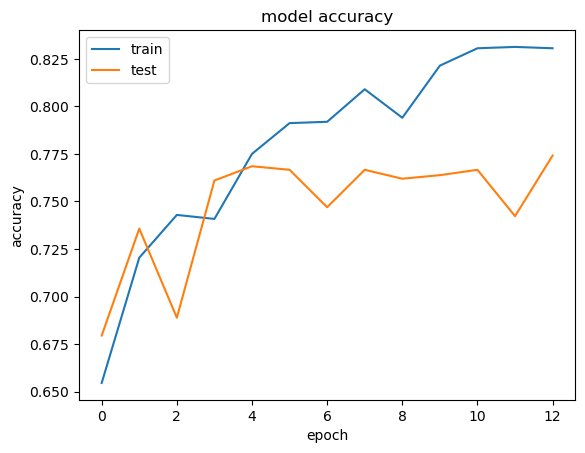

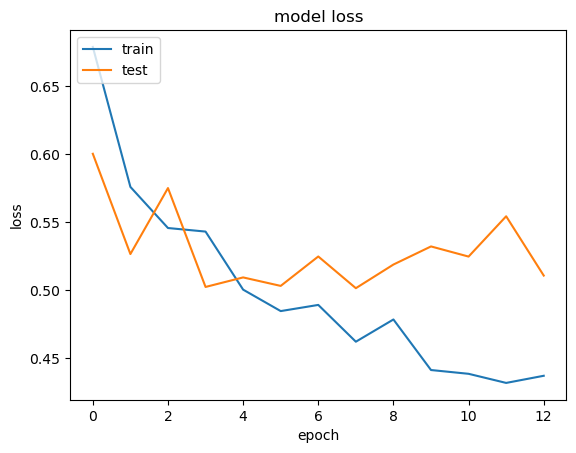

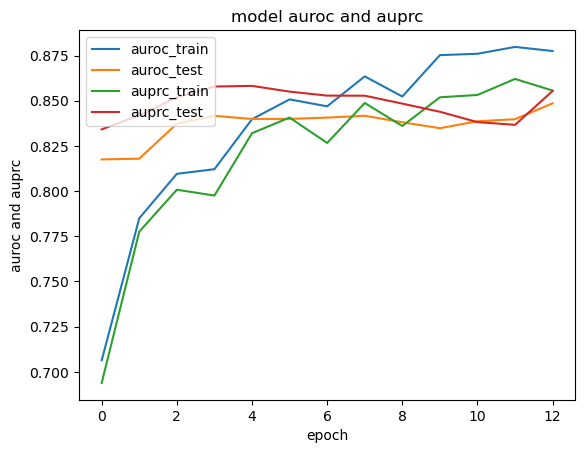

INFO:tensorflow:Assets written to: best_models/best_model5_AARS_K562/assets


INFO:tensorflow:Assets written to: best_models/best_model5_AARS_K562/assets


45/45 [==============================] - 0s 3ms/step
Prediction saved.
Time passed: 0hour:27min:34sec


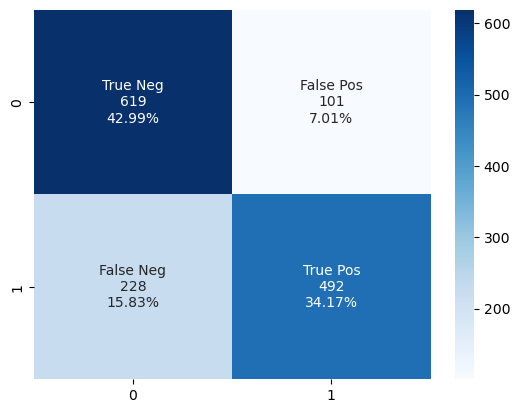

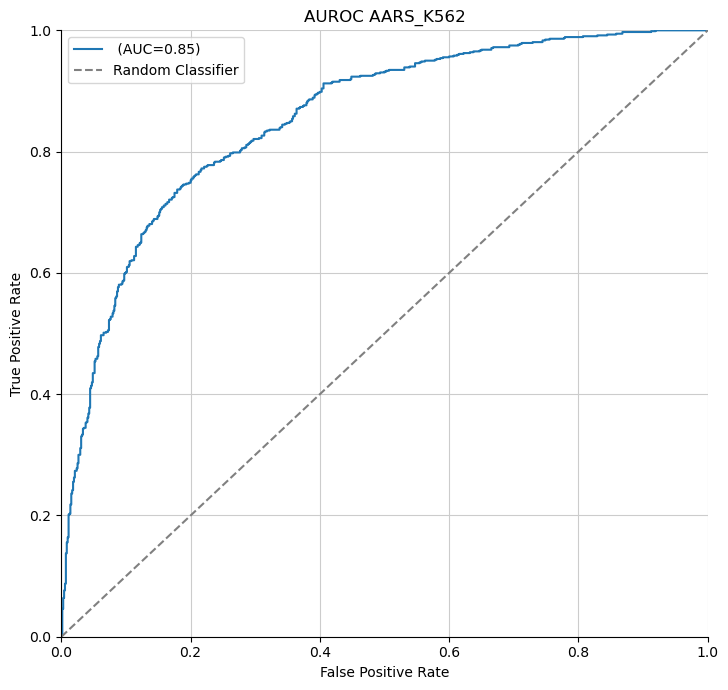

In [48]:
#change to function the majority of the notebook !! 

path = '/lustre/groups/crna01/workspace/sofia/gencode/processed/ENCODE-Sofia/'
directory1 = os.listdir(path)


tic()

for folder in directory1:
    if folder == 'AARS_K562':
    
        #preparation of the dataset from the respective folder 
        x_train ,y_train ,x_val ,y_val ,x_test ,y_test = prepare_dataset(path, folder)

        #prepare and save the best model in the respective folder 
        prepare_best_model(x_train ,y_train ,x_val ,y_val ,x_test ,y_test, folder) 

        #evaluation and storage of the predicted labels
        model_path = ('best_models/best_model_%s' % folder)
        testing_model(model_path , folder, x_test, y_test)
tac()
    

Starting preparation of the dataset for AGGF1_K562
Shape of labels: 
-positive :  (14833, 1) 
-negative :  (14833, 1) 
-positive validation :  (3587, 1) 
-negative validation :  (3587, 1)
Shape of datasets: 
-training set :  (23732, 400, 4) 
-validation set :  (5934, 400, 4) 
-testing set :  (7174, 400, 4)
Label frequencies among the dataset AGGF1_K562


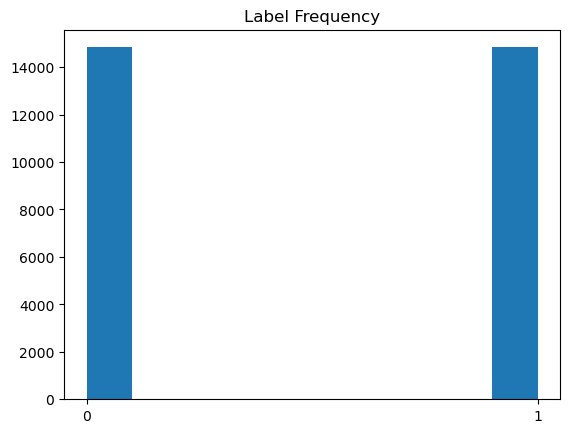

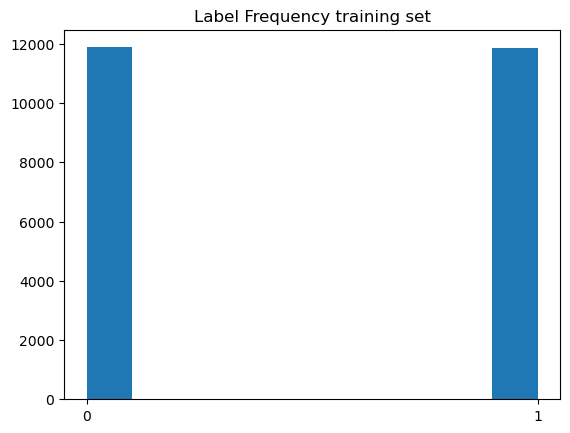

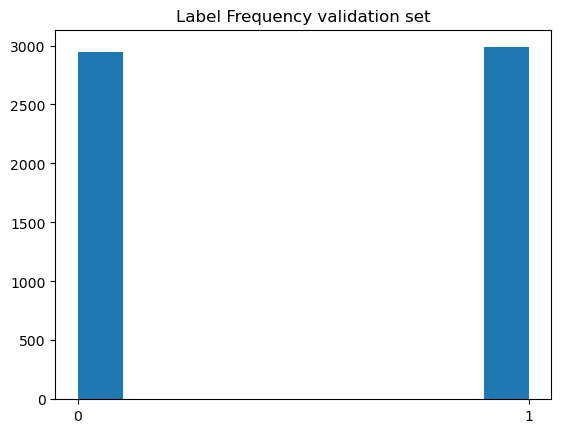

Epoch 1/200
742/742 [==============================] - 10s 9ms/step - loss: 0.5109 - tp: 8452.0000 - fp: 2367.0000 - tn: 9517.0000 - fn: 3396.0000 - accuracy: 0.7572 - precision: 0.7812 - recall: 0.7134 - auroc: 0.8287 - auprc: 0.8404 - val_loss: 0.3693 - val_tp: 2414.0000 - val_fp: 312.0000 - val_tn: 2637.0000 - val_fn: 571.0000 - val_accuracy: 0.8512 - val_precision: 0.8855 - val_recall: 0.8087 - val_auroc: 0.9222 - val_auprc: 0.9333
Epoch 2/200
742/742 [==============================] - 5s 6ms/step - loss: 0.4384 - tp: 9279.0000 - fp: 1919.0000 - tn: 9965.0000 - fn: 2569.0000 - accuracy: 0.8109 - precision: 0.8286 - recall: 0.7832 - auroc: 0.8761 - auprc: 0.8877 - val_loss: 0.3834 - val_tp: 2238.0000 - val_fp: 161.0000 - val_tn: 2788.0000 - val_fn: 747.0000 - val_accuracy: 0.8470 - val_precision: 0.9329 - val_recall: 0.7497 - val_auroc: 0.9170 - val_auprc: 0.9331
Epoch 3/200
742/742 [==============================] - 5s 7ms/step - loss: 0.4275 - tp: 9409.0000 - fp: 1760.0000 - tn: 1

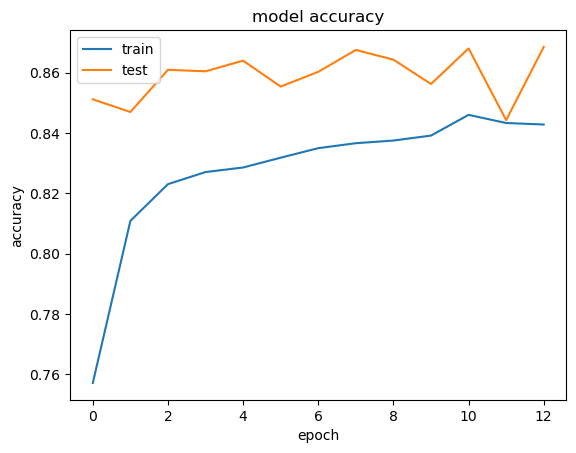

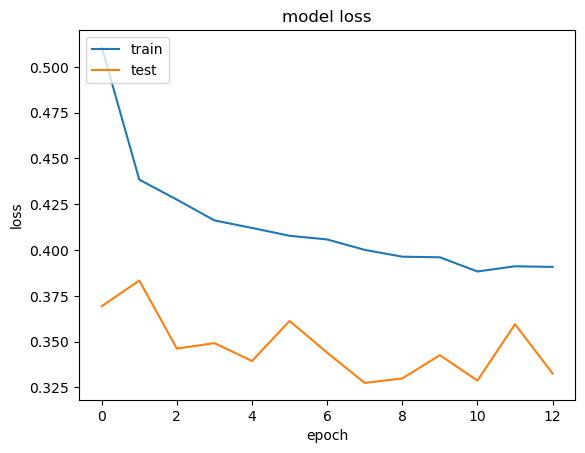

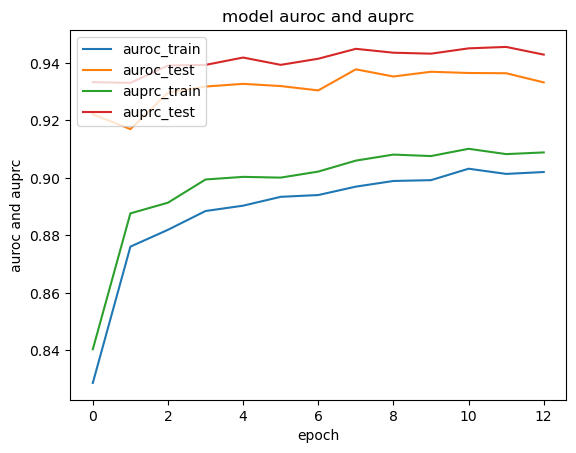

INFO:tensorflow:Assets written to: best_models/best_model_AGGF1_K562/assets


INFO:tensorflow:Assets written to: best_models/best_model_AGGF1_K562/assets


225/225 [==============================] - 1s 2ms/step
Prediction saved.
Starting preparation of the dataset for AATF_K562
Shape of labels: 
-positive :  (4616, 1) 
-negative :  (4616, 1) 
-positive validation :  (1201, 1) 
-negative validation :  (1201, 1)
Shape of datasets: 
-training set :  (7385, 400, 4) 
-validation set :  (1847, 400, 4) 
-testing set :  (2402, 400, 4)
Label frequencies among the dataset AATF_K562


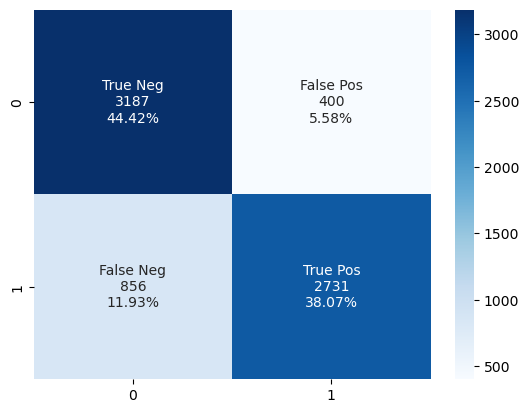

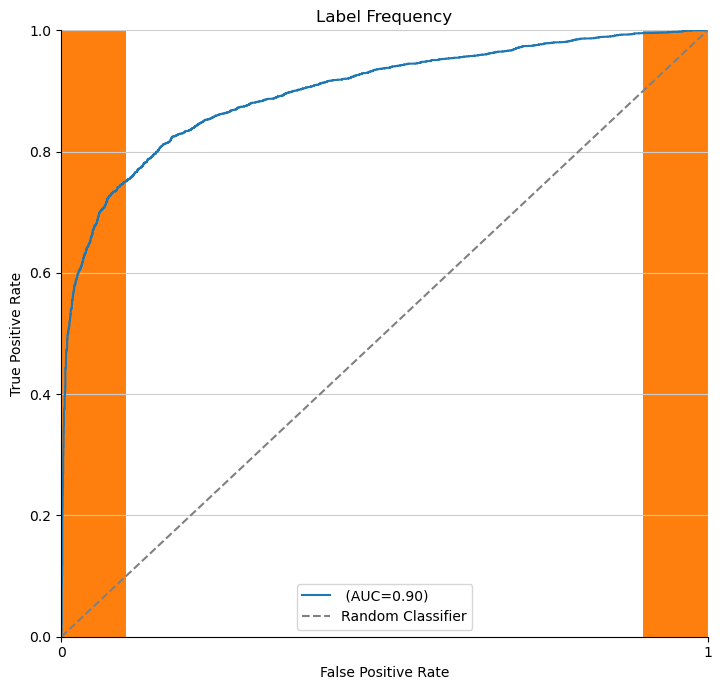

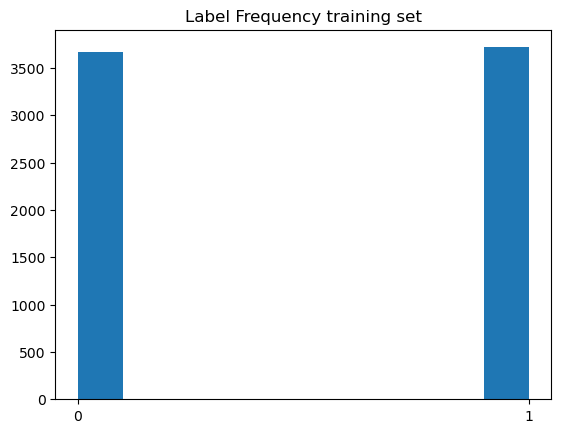

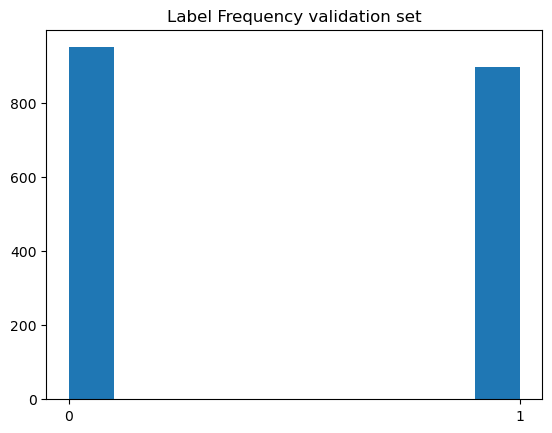

Epoch 1/200
231/231 [==============================] - 3s 9ms/step - loss: 0.4989 - tp: 2796.0000 - fp: 683.0000 - tn: 2983.0000 - fn: 923.0000 - accuracy: 0.7825 - precision: 0.8037 - recall: 0.7518 - auroc: 0.8365 - auprc: 0.8397 - val_loss: 0.4537 - val_tp: 689.0000 - val_fp: 155.0000 - val_tn: 795.0000 - val_fn: 208.0000 - val_accuracy: 0.8035 - val_precision: 0.8164 - val_recall: 0.7681 - val_auroc: 0.8812 - val_auprc: 0.8784
Epoch 2/200
231/231 [==============================] - 2s 7ms/step - loss: 0.4764 - tp: 2908.0000 - fp: 647.0000 - tn: 3019.0000 - fn: 811.0000 - accuracy: 0.8026 - precision: 0.8180 - recall: 0.7819 - auroc: 0.8513 - auprc: 0.8409 - val_loss: 0.5135 - val_tp: 811.0000 - val_fp: 352.0000 - val_tn: 598.0000 - val_fn: 86.0000 - val_accuracy: 0.7629 - val_precision: 0.6973 - val_recall: 0.9041 - val_auroc: 0.8743 - val_auprc: 0.8624
Epoch 3/200
231/231 [==============================] - 2s 7ms/step - loss: 0.4699 - tp: 2974.0000 - fp: 709.0000 - tn: 2957.0000 - 

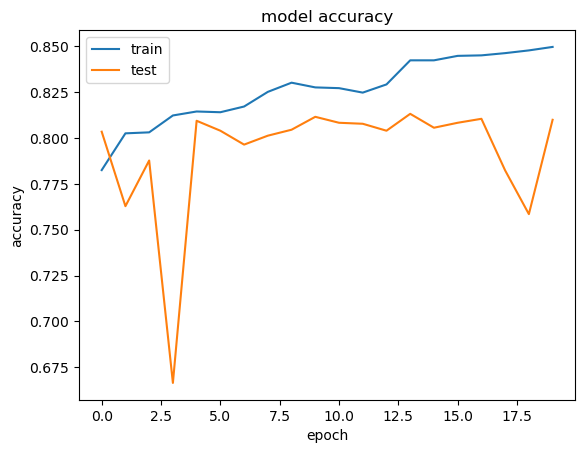

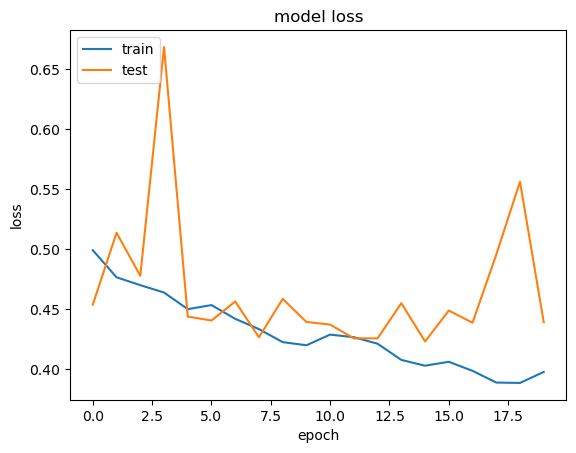

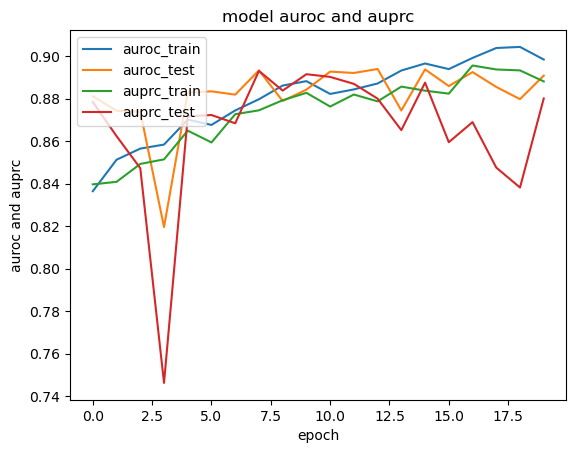

INFO:tensorflow:Assets written to: best_models/best_model_AATF_K562/assets


INFO:tensorflow:Assets written to: best_models/best_model_AATF_K562/assets


76/76 [==============================] - 0s 2ms/step
Prediction saved.
Starting preparation of the dataset for AGGF1_HepG2
Shape of labels: 
-positive :  (13326, 1) 
-negative :  (13326, 1) 
-positive validation :  (3559, 1) 
-negative validation :  (3559, 1)
Shape of datasets: 
-training set :  (21321, 400, 4) 
-validation set :  (5331, 400, 4) 
-testing set :  (7118, 400, 4)
Label frequencies among the dataset AGGF1_HepG2


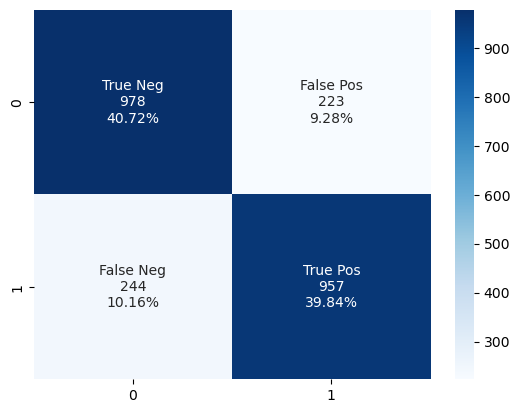

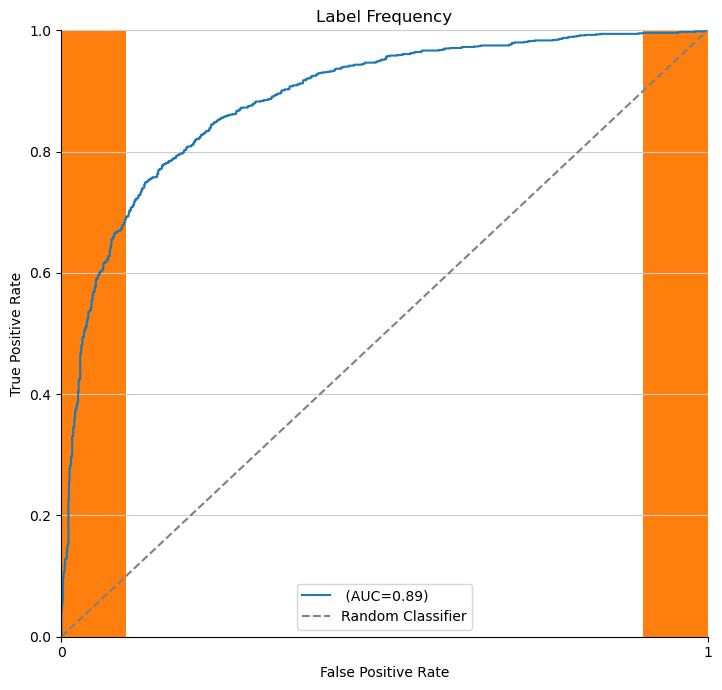

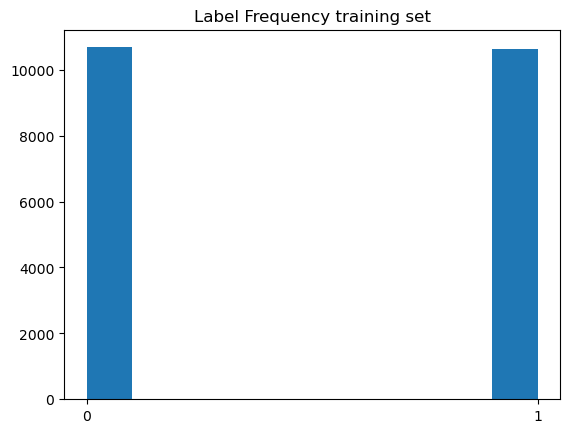

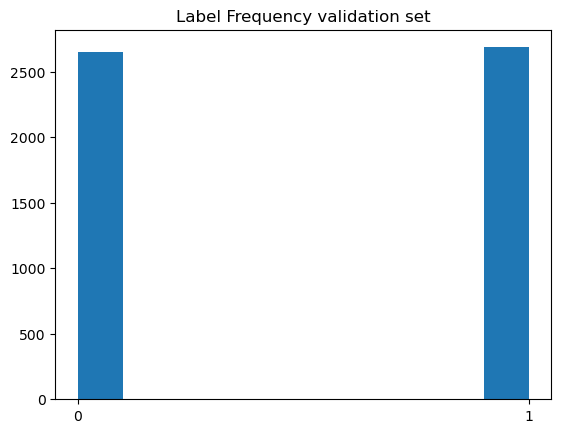

Epoch 1/200
667/667 [==============================] - 7s 8ms/step - loss: 0.5532 - tp: 7660.0000 - fp: 2753.0000 - tn: 7927.0000 - fn: 2981.0000 - accuracy: 0.7311 - precision: 0.7356 - recall: 0.7199 - auroc: 0.7940 - auprc: 0.7814 - val_loss: 0.4639 - val_tp: 1992.0000 - val_fp: 398.0000 - val_tn: 2248.0000 - val_fn: 693.0000 - val_accuracy: 0.7953 - val_precision: 0.8335 - val_recall: 0.7419 - val_auroc: 0.8831 - val_auprc: 0.8825
Epoch 2/200
667/667 [==============================] - 4s 6ms/step - loss: 0.4923 - tp: 8294.0000 - fp: 2330.0000 - tn: 8350.0000 - fn: 2347.0000 - accuracy: 0.7806 - precision: 0.7807 - recall: 0.7794 - auroc: 0.8428 - auprc: 0.8318 - val_loss: 0.4337 - val_tp: 2373.0000 - val_fp: 738.0000 - val_tn: 1908.0000 - val_fn: 312.0000 - val_accuracy: 0.8030 - val_precision: 0.7628 - val_recall: 0.8838 - val_auroc: 0.8972 - val_auprc: 0.8959
Epoch 3/200
667/667 [==============================] - 4s 6ms/step - loss: 0.4817 - tp: 8391.0000 - fp: 2265.0000 - tn: 84

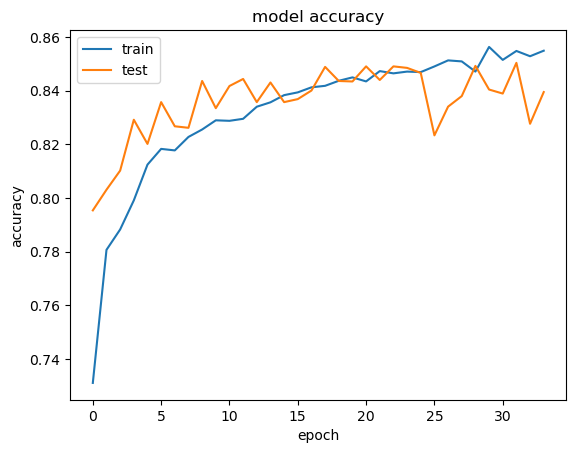

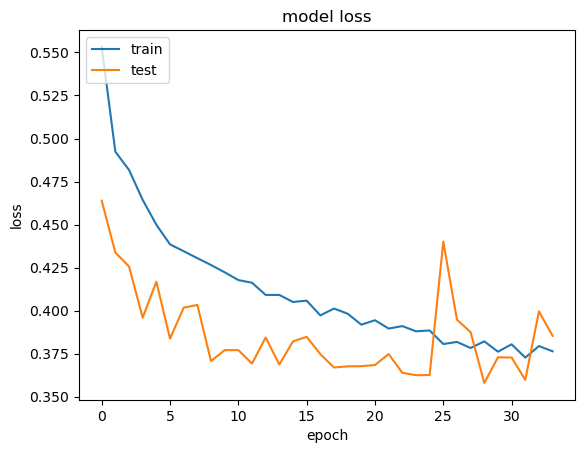

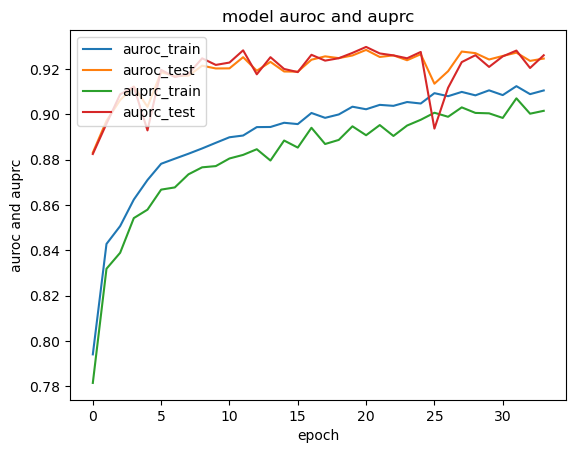

INFO:tensorflow:Assets written to: best_models/best_model_AGGF1_HepG2/assets


INFO:tensorflow:Assets written to: best_models/best_model_AGGF1_HepG2/assets


223/223 [==============================] - 1s 2ms/step
Prediction saved.
Starting preparation of the dataset for AKAP1_HepG2
Shape of labels: 
-positive :  (15020, 1) 
-negative :  (15020, 1) 
-positive validation :  (3969, 1) 
-negative validation :  (3969, 1)
Shape of datasets: 
-training set :  (24032, 400, 4) 
-validation set :  (6008, 400, 4) 
-testing set :  (7938, 400, 4)
Label frequencies among the dataset AKAP1_HepG2


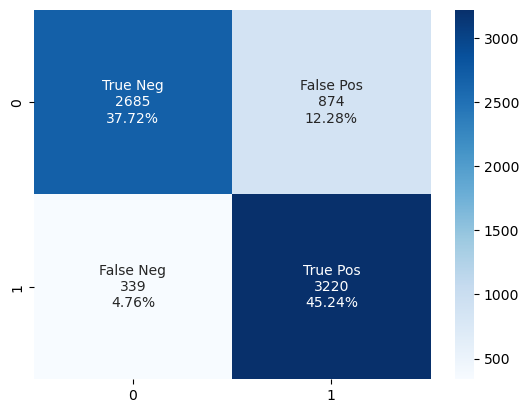

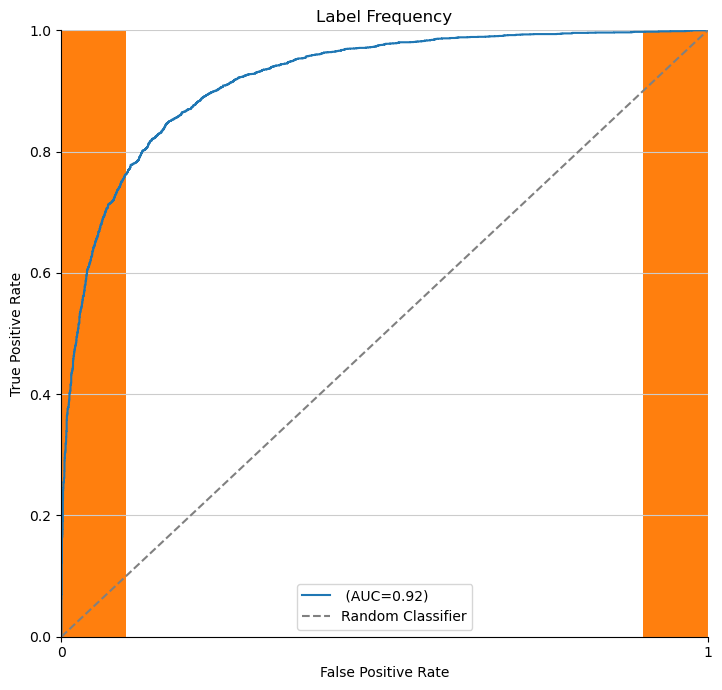

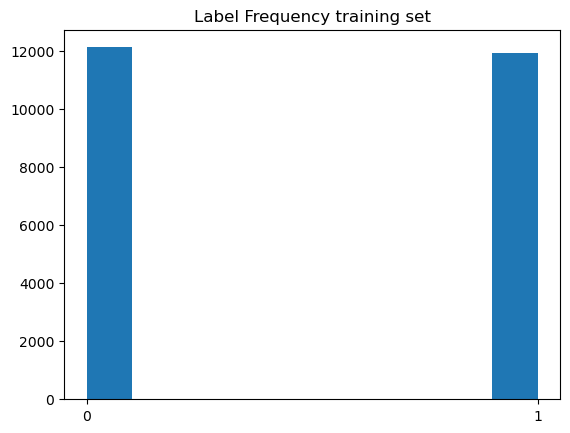

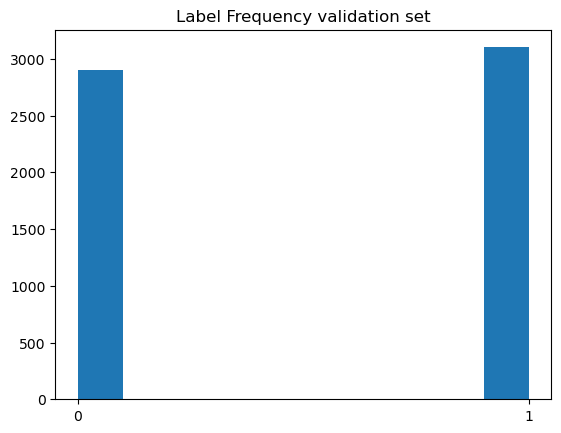

Epoch 1/200
751/751 [==============================] - 6s 7ms/step - loss: 0.5835 - tp: 8532.0000 - fp: 3373.0000 - tn: 8741.0000 - fn: 3386.0000 - accuracy: 0.7188 - precision: 0.7167 - recall: 0.7159 - auroc: 0.7630 - auprc: 0.7290 - val_loss: 0.5259 - val_tp: 2405.0000 - val_fp: 757.0000 - val_tn: 2149.0000 - val_fn: 697.0000 - val_accuracy: 0.7580 - val_precision: 0.7606 - val_recall: 0.7753 - val_auroc: 0.8261 - val_auprc: 0.8127
Epoch 2/200
751/751 [==============================] - 4s 6ms/step - loss: 0.5604 - tp: 8849.0000 - fp: 3175.0000 - tn: 8939.0000 - fn: 3069.0000 - accuracy: 0.7402 - precision: 0.7359 - recall: 0.7425 - auroc: 0.7848 - auprc: 0.7503 - val_loss: 0.5366 - val_tp: 2201.0000 - val_fp: 573.0000 - val_tn: 2333.0000 - val_fn: 901.0000 - val_accuracy: 0.7547 - val_precision: 0.7934 - val_recall: 0.7095 - val_auroc: 0.8169 - val_auprc: 0.8001
Epoch 3/200
751/751 [==============================] - 4s 6ms/step - loss: 0.5517 - tp: 8831.0000 - fp: 2981.0000 - tn: 91

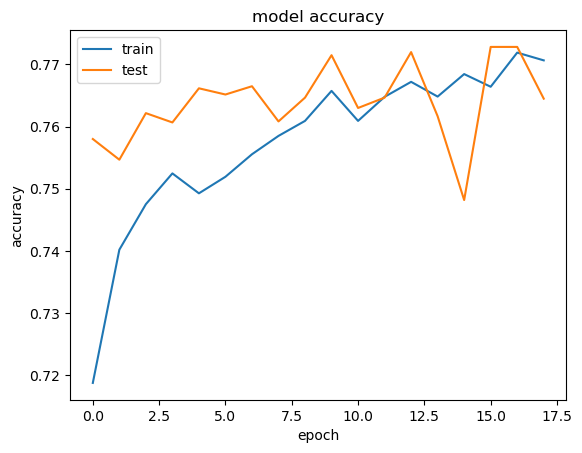

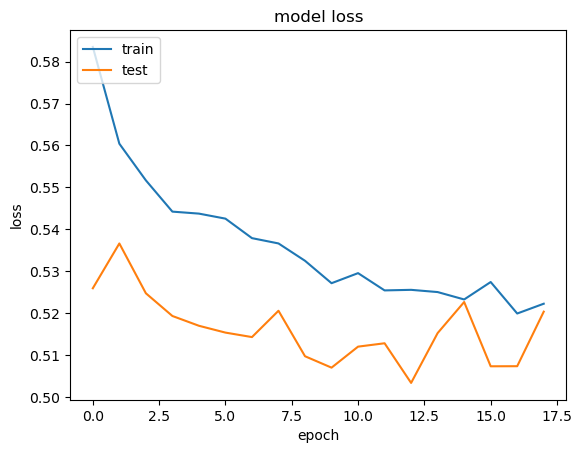

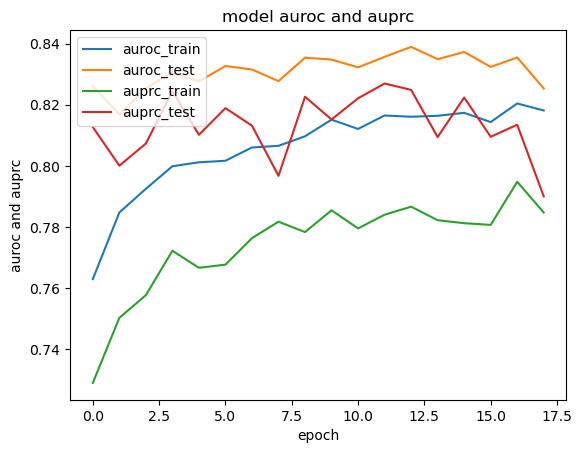

INFO:tensorflow:Assets written to: best_models/best_model_AKAP1_HepG2/assets


INFO:tensorflow:Assets written to: best_models/best_model_AKAP1_HepG2/assets


249/249 [==============================] - 1s 2ms/step
Prediction saved.


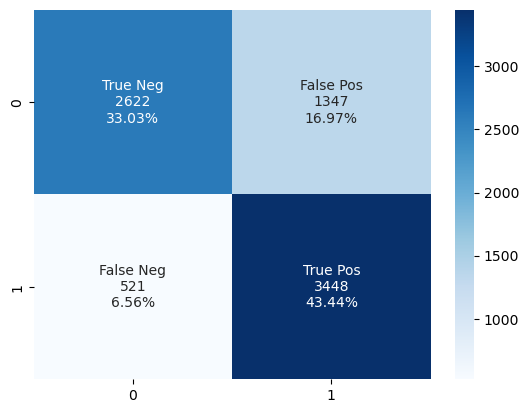

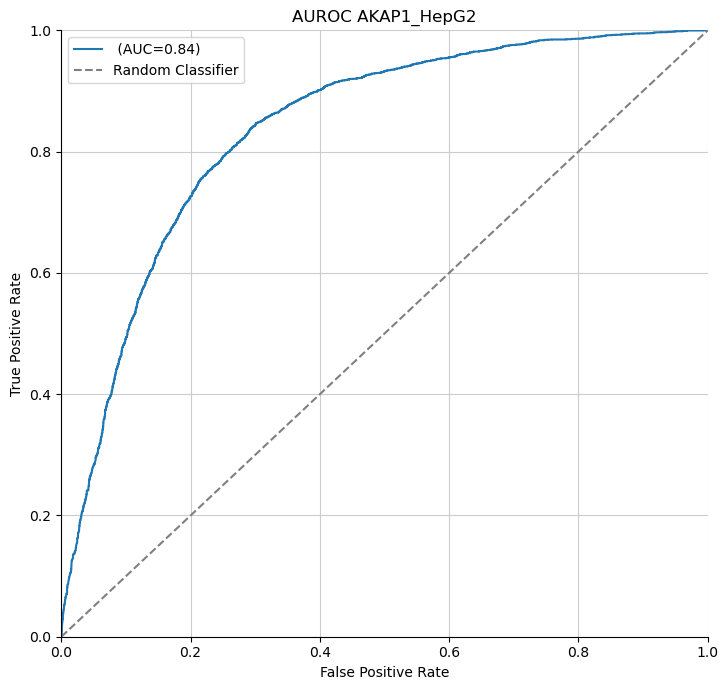

In [22]:
#testing of the best model on other folders
path = '/lustre/groups/crna01/workspace/sofia/gencode/processed/ENCODE-Sofia/'
directory1 = os.listdir(path)

tic()

for folder in directory1:
    if folder in ['AATF_K562', 'BCF1_K562', 'AGGF1_HepG2', 'AGGF1_K562', 'AKAP1_HepG2']:
        
        #preparation of the dataset from the respective folder 
        x_train ,y_train ,x_val ,y_val ,x_test ,y_test = prepare_dataset(path, folder)
        
        #training the model on the new datasets
        
        model = training_model(x_train ,y_train ,x_val ,y_val ,x_test ,y_test, folder)
        
        #evaluation and storage of the predicted labels
        model_path = ('best_models/best_model_%s' %folder)
        testing_model(model_path , folder, x_test, y_test)
        
tac()